# Problem Description and Data

This project aims to generate Monet-style paintings using a Generative Adversarial Network (GAN). By training on a dataset of 300 Monet paintings and 7,028 photos, the model learns to transform ordinary photos into images with Monet’s distinctive style.  The goal is to gerate images that replicate the Monet style and can pass the classifier as real Monets.

In [ ]:
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Input, Dense, Reshape, Conv2DTranspose, Conv2D, BatchNormalization, ReLU,
    LeakyReLU, Flatten, Dropout, Concatenate
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Load Data
from google.colab import files
files.upload()

In [5]:
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

In [6]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle competitions files -c gan-getting-started

Next Page Token = CfDJ8GrUjsAKvhxNhvm67MmtKLlQfDGhinYcviIZ6R75BjBoGAB_xs5C1s30dviKSGLYeaXOe_1GViiTh98CHC90zXg
name                      size  creationDate         
------------------------  ----  -------------------  
photo_jpg/009ddaed1f.jpg  16KB  2020-08-25 20:07:18  
photo_jpg/003aab6fdd.jpg  23KB  2020-08-25 20:07:18  
photo_jpg/009d534136.jpg  13KB  2020-08-25 20:07:18  
photo_jpg/00479e2a21.jpg   6KB  2020-08-25 20:07:18  
photo_jpg/00068bc07f.jpg  14KB  2020-08-25 20:07:18  
photo_jpg/00c6a0ad1e.jpg  19KB  2020-08-25 20:07:18  
photo_jpg/0033c5f971.jpg   9KB  2020-08-25 20:07:18  
photo_jpg/00aeb60e25.jpg  13KB  2020-08-25 20:07:18  
photo_jpg/003c6c30e0.jpg  14KB  2020-08-25 20:07:18  
photo_jpg/001158d595.jpg  11KB  2020-08-25 20:07:18  
photo_jpg/000910d219.jpg  15KB  2020-08-25 20:07:18  
photo_jpg/00104fd531.jpg   8KB  2020-08-25 20:07:18  
photo_jpg/000ded5c41.jpg  10KB  2020-08-25 20:07:18  
photo_jpg/00882b7e1d.jpg   8KB  2020-08-25 20:07:18  
photo_jpg/0080f94ebc.jpg  

In [8]:
!kaggle competitions download -c gan-getting-started

 99% 364M/367M [00:17<00:00, 19.2MB/s]
100% 367M/367M [00:17<00:00, 22.1MB/s]


In [9]:
import zipfile

with zipfile.ZipFile('/content/gan-getting-started.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/monet_dataset')

# Data Preparation and Preprocessing

The Monet paintings and regular photo datasets are processed to make them suitable for GAN training. The images are loaded and resized to a standard dimension of 256x256 pixels. Then the pixel values are normalized to a range between -1 and 1. This normalization helps the GAN model train more effectively, as the pixel intensities are centered around zero.

To streamline training, the datasets are batched, shuffled, and prefetched. Prefetching allows data to be loaded in parallel with training, reducing the time between each training step.

In [10]:
monet_dir = '/content/monet_dataset/monet_jpg'
photo_dir = '/content/monet_dataset/photo_jpg'
img_height, img_width = 256, 256  # Standardize image size
batch_size = 8

In [11]:
# Define a function to load and preprocess images
def load_and_preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    img = (tf.cast(img, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    return img

# Load and preprocess Monet and photo images directly into tf.data.Datasets
monet_images = tf.data.Dataset.list_files(f"{monet_dir}/*.jpg")
photo_images = tf.data.Dataset.list_files(f"{photo_dir}/*.jpg")

# Apply preprocessing to each dataset
monet_dataset = monet_images.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
photo_dataset = photo_images.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle, batch, and prefetch each dataset
monet_dataset = monet_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
photo_dataset = photo_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Zip the datasets to provide paired inputs for the CycleGAN model
training_dataset = tf.data.Dataset.zip((monet_dataset, photo_dataset))

# Exploratory Data Analysis

Let's visual a batch of images from the dataset to get a sense of the visual characteristics of them.



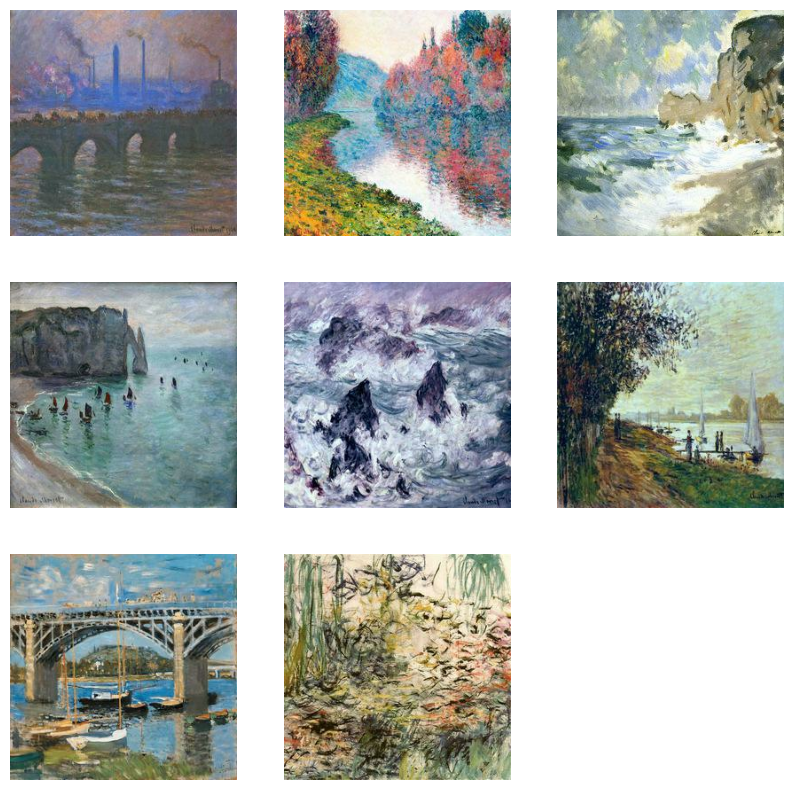

In [12]:
# Function to display a batch of images from a TensorFlow dataset
def display_batch(dataset, num_images):
    plt.figure(figsize=(10, 10))
    for images in dataset.take(1):  # Take a single batch of images
        for i in range(min(num_images, images.shape[0])):  # Ensure i < batch size
            plt.subplot(3, 3, i + 1)
            plt.imshow((images[i] * 0.5 + 0.5).numpy())  # Rescale to [0, 1] for display
            plt.axis("off")
    plt.show()

display_batch(monet_dataset, num_images=8)

# Model Architecture

Generator Network

The generator is designed to translate images between the photo and Monet domains. A U-Net-like architecture with skip connections was used, which helps preserve details while applying Monet’s artistic style. The network includes downsampling and upsampling layers:     

Downsampling Layers: These layers progressively reduce the spatial dimensions while increasing the feature depth, capturing essential style features.

Upsampling Layers: These layers increase spatial dimensions to reconstruct the image, adding Monet-like textures and colors.


Discriminator Network

The discriminator is a convolutional neural network that distinguishes between real Monet paintings and generated images. The network downsamples the image using convolutional layers with BatchNormalization and LeakyReLU activation, making it well-suited to identifying differences in textures and patterns.

In [13]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())
    return result


In [14]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    result.add(BatchNormalization())

    if apply_dropout:
        result.add(Dropout(0.5))

    result.add(ReLU())
    return result

In [15]:
OUTPUT_CHANNELS=3

def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [16]:
# Build Dicriminator
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = BatchNormalization()(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

The GAN model employs three main loss functions:  

Adversarial Loss: Encourages the generator to produce images indistinguishable from real Monet paintings.

Cycle Consistency Loss: Ensures that an image translated to the Monet domain and back remains similar to the original, maintaining content consistency.

Identity Loss: Helps retain color and structure when the generator is applied to images from its target domain, promoting stylistic continuity.

In [17]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return real_loss + generated_loss

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [18]:
# Cycle and identity loss use mean absolute error (L1 loss)
LAMBDA = 10

def cycle_loss(real_image, cycled_image):
    return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image):
    return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))

In [19]:
generator_g_optimizer = tf.keras.optimizers.Adam(5e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(5e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(5e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(5e-4, beta_1=0.5)

In [20]:
monet_generator = Generator()  # Monet to photo
photo_generator = Generator()  # Photo to Monet
monet_discriminator = Discriminator()  # Discriminates Monet images
photo_discriminator = Discriminator()  # Discriminates photo images

In [21]:
@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:
        # Generate images
        fake_photo = monet_generator(real_monet, training=True)
        cycled_monet = photo_generator(fake_photo, training=True)

        fake_monet = photo_generator(real_photo, training=True)
        cycled_photo = monet_generator(fake_monet, training=True)

        # Identity mappings
        same_monet = photo_generator(real_monet, training=True)
        same_photo = monet_generator(real_photo, training=True)

        # Discriminator outputs
        disc_real_monet = monet_discriminator(real_monet, training=True)
        disc_real_photo = photo_discriminator(real_photo, training=True)

        disc_fake_monet = monet_discriminator(fake_monet, training=True)
        disc_fake_photo = photo_discriminator(fake_photo, training=True)

        # Compute losses
        gen_g_loss = generator_loss(disc_fake_photo)
        gen_f_loss = generator_loss(disc_fake_monet)

        total_cycle_loss = cycle_loss(real_monet, cycled_monet) + cycle_loss(real_photo, cycled_photo)

        # Total generator loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_photo, same_photo)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_monet, same_monet)

        disc_x_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        disc_y_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

    # Calculate the gradients and apply optimizers
    generator_g_gradients = tape.gradient(total_gen_g_loss, monet_generator.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, photo_generator.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, monet_discriminator.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, photo_discriminator.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, monet_generator.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, photo_generator.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, monet_discriminator.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, photo_discriminator.trainable_variables))

In [22]:
# Display progress of images
def display_generated_images(generator, real_images, num_images=3):
    plt.figure(figsize=(10, 5))

    for i in range(num_images):
        # Display real image
        plt.subplot(2, num_images, i + 1)
        plt.imshow((real_images[i] * 0.5 + 0.5).numpy())  # Rescale to [0, 1]
        plt.title("Real")
        plt.axis("off")

        # Generate and display fake image
        fake_image = generator(tf.expand_dims(real_images[i], 0), training=False)
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow((fake_image[0] * 0.5 + 0.5).numpy())  # Rescale to [0, 1]
        plt.title("Generated")
        plt.axis("off")

    plt.show()

Training Loop

The model is trained for 25 epochs, with real and generated images displayed every 5 epochs to monitor progress. Each epoch includes multiple training steps where the generator and discriminator are updated in an alternating fashion, balancing their objectives.

# Results and Analysis

Starting epoch 1/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 1 is 110.99 sec
Starting epoch 2/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 2 is 50.17 sec
Starting epoch 3/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 3 is 52.06 sec
Starting epoch 4/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 4 is 51.32 sec
Starting epoch 5/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 5 is 51.48 sec
Epoch 5: Displaying real and generated images...


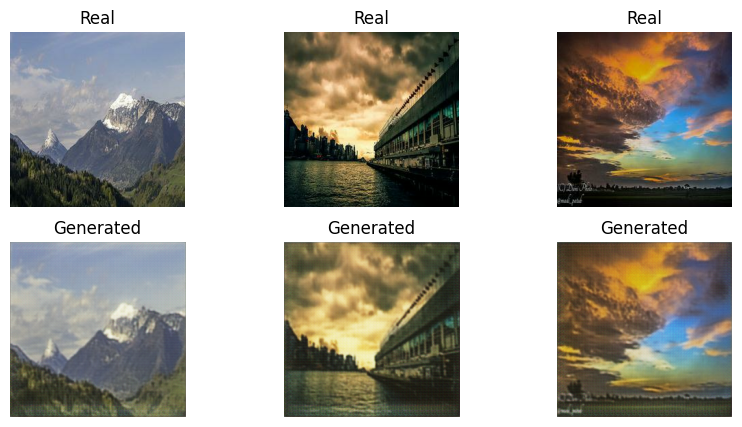

Starting epoch 6/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 6 is 51.32 sec
Starting epoch 7/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 7 is 51.40 sec
Starting epoch 8/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 8 is 51.33 sec
Starting epoch 9/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 9 is 51.38 sec
Starting epoch 10/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 10 is 51.84 sec
Epoch 10: Displaying real and generated images...


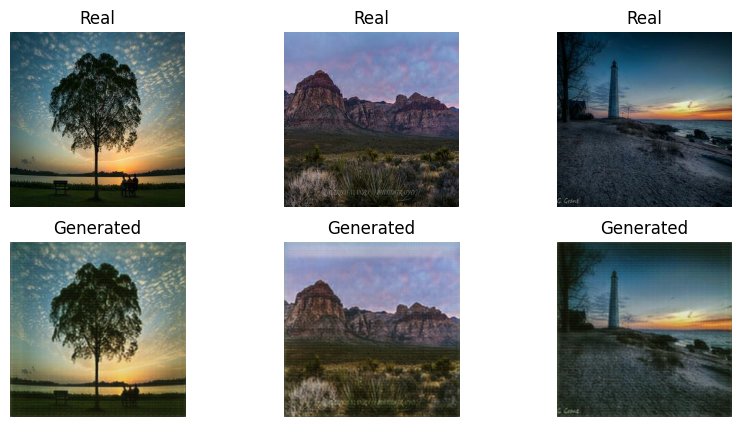

Starting epoch 11/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 11 is 51.10 sec
Starting epoch 12/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 12 is 51.18 sec
Starting epoch 13/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 13 is 51.30 sec
Starting epoch 14/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 14 is 51.35 sec
Starting epoch 15/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 15 is 51.08 sec
Epoch 15: Displaying real and generated images...


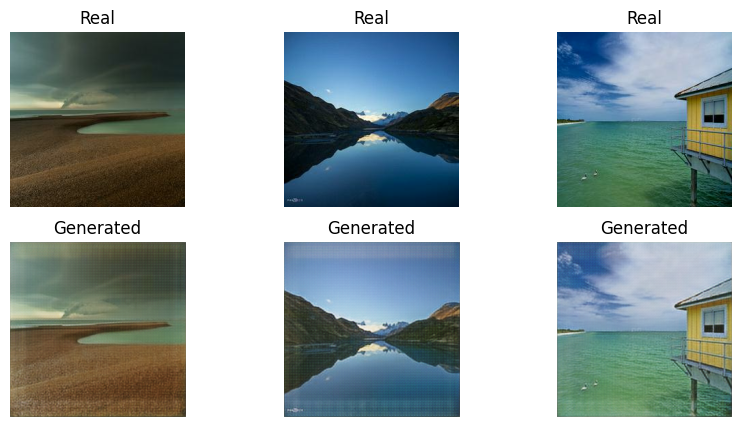

Starting epoch 16/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 16 is 51.53 sec
Starting epoch 17/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 17 is 52.15 sec
Starting epoch 18/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 18 is 51.72 sec
Starting epoch 19/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 19 is 51.36 sec
Starting epoch 20/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 20 is 51.33 sec
Epoch 20: Displaying real and generated images...


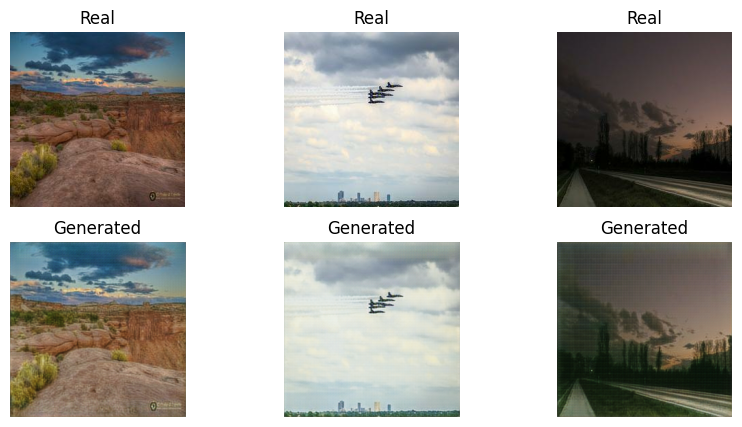

Starting epoch 21/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 21 is 51.43 sec
Starting epoch 22/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 22 is 51.26 sec
Starting epoch 23/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 23 is 51.24 sec
Starting epoch 24/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 24 is 51.40 sec
Starting epoch 25/25
Processing batch 1
Processing batch 11
Processing batch 21
Processing batch 31
Time taken for epoch 25 is 52.08 sec
Epoch 25: Displaying real and generated images...


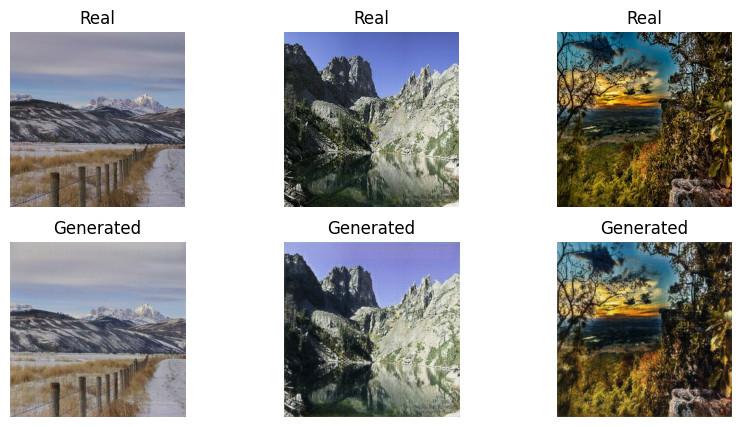

In [23]:
import time

EPOCHS = 25
display_interval = 5

for epoch in range(EPOCHS):
    print(f"Starting epoch {epoch + 1}/{EPOCHS}")
    start = time.time()

    for step, (real_monet, real_photo) in enumerate(training_dataset):
        if step % 10 == 0:
            print(f"Processing batch {step + 1}")
        train_step(real_monet, real_photo)

    print(f"Time taken for epoch {epoch + 1} is {time.time()-start:.2f} sec")

    # Display real and fake images every few epochs
    if (epoch + 1) % display_interval == 0:
        print(f"Epoch {epoch + 1}: Displaying real and generated images...")
        for photo_batch in photo_dataset.take(1):
            display_generated_images(photo_generator, photo_batch)

After 25 epochs, the generated images already look pretty close to the real images although there is still some blur.  Running more epochs would likely improve the overall quality but the training time is pretty long so I stopped at 25

In [27]:
# Create images for Kaggle submission
from PIL import Image
import zipfile

# Set parameters
latent_dim = 100
batch_size = 16
EPOCHS = 25
num_images_to_generate = 7000
output_dir = "/content/generated_images"
output_zip = "/content/images.zip"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Define generator model
def build_generator(latent_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(latent_dim,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape((8, 8, 256)),
        tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(4, 4), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Instantiate generator
generator = build_generator(latent_dim)

# Generate and save images
def generate_and_save_images(generator, num_images, output_dir, latent_dim):
    for i in range(num_images):
        noise = tf.random.normal([1, latent_dim])
        generated_image = generator(noise, training=False)
        generated_image = ((generated_image[0] + 1) * 127.5).numpy().astype(np.uint8)  # Rescale to [0, 255]
        file_path = os.path.join(output_dir, f"image_{i + 1}.jpg")
        tf.keras.utils.save_img(file_path, generated_image)
    print(f"Generated {num_images} images in {output_dir}.")

# Zip images for submission
def zip_images(output_dir, output_zip):
    with zipfile.ZipFile(output_zip, "w") as zf:
        for root, _, files in os.walk(output_dir):
            for file in files:
                zf.write(os.path.join(root, file), arcname=file)
    print(f"Zipped images to {output_zip}.")

# Generate images and zip them
generate_and_save_images(generator, num_images_to_generate, output_dir, latent_dim)
zip_images(output_dir, output_zip)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generated 7000 images in /content/generated_images.
Zipped images to /content/images.zip.


In [28]:
from google.colab import files
files.download(output_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The Kaggle file upload submission is greyed out so I couldn't submit my images for scoring.

# Conclusions

Throughout the training the images show improvement where there was more blur in the initial images and as training went on the images continued to improve and look more like the real images.  I opted to stop training at 25 epochs because of the time it took but the results were already pretty impressive.  Increasing the epochs would give the model more time to train and fine tune the images.  

Training time was a big factor in the project so I experimented with various settings to balance speed and image quality. I modified variables like reducing the batch size to speed things up.  I also initially tried to work on lower resolution images to speed up training but the model wasn't effectively learning so I changed to using 256 x 256 which helped significantly in the final output.